In [28]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

O dataset traz um código que ja divide as imagens em 80% treino, 10% validação e 10% teste então eu não fiz train_tes_split. Só direcionei os diretórios. 

In [30]:
# Definir diretórios dos conjuntos de imagens
train_dir = "./pokemon-dataset-1000 - Copia/train"
val_dir = "./pokemon-dataset-1000 - Copia/val"
test_dir = "./pokemon-dataset-1000 - Copia/test"

**`img_size`** : Define o tamanho de cada imagem que será alimentada ao modelo. Como o modelo de CNN está criando está lidando com imagens, é necessário garantir que todas as imagens sejam redimensionadas para um tamanho comum antes de serem passadas para a rede.  
**OBS:** A escolha de 128x128 é um equilíbrio comum entre qualidade da imagem e exigência de recursos computacionais. Imagens maiores poderiam proporcionar mais detalhes, mas também aumentariam o custo computacional e o tempo de treinamento. Imagens menores, por outro lado, podem perder informações importantes.  

**`batch_size`** : Define o número de imagens que serão passadas pela rede neural em uma única iteração durante o treinamento.  
**OBS:** Um batch grande (ex: 64, 128, 256) pode acelerar o treinamento e melhorar a estabilidade da estimativa do gradiente, mas exigirá mais memória e pode tornar o modelo mais propenso a ficar preso em mínimos locais (menor diversidade nos gradientes); já um batch pequeno (ex: 16, 8, 4) pode tornar o treinamento mais ruidoso (maior variabilidade nos gradientes), mas muitas vezes melhora a generalização e pode ser mais adequado se a memória for limitada.

In [31]:
# Parâmetros
img_size = (128, 128)
batch_size = 32

As imagens geralmente têm valores de pixel entre 0 e 255 (para imagens em RGB). No entanto, as redes neurais geralmente funcionam melhor quando os valores dos pixels estão em uma faixa menor, como [0, 1] em vez de [0, 255].
Para isso, o parâmetro rescale=1.0 / 255.0 é utilizado. Ele divide os valores dos pixels por 255, o que transforma os valores de pixel de uma faixa de [0, 255] para uma faixa de [0, 1].

**OBS:** A normalização ajuda a acelerar o processo de treinamento, pois pode reduzir a variabilidade nos gradientes e melhorar a convergência. Também pode ajudar o modelo a se ajustar de maneira mais eficiente aos dados.

In [32]:
# Pré-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

**`train_datagen:`** Este é o objeto de pré-processamento que foi configurado anteriormente (com a normalização dos pixels e, possivelmente, aumentos de dados, caso tenha sido configurado).  

**`flow_from_directory(train_dir):`** Este método cria um gerador que irá buscar as imagens no diretório train_dir (diretório que contém as imagens de treinamento). As imagens devem estar organizadas em subpastas, onde cada subpasta representa uma classe. O nome da subpasta será usado como o rótulo da classe.  

**`target_size=img_size:`** Redimensiona todas as imagens para o tamanho especificado (no seu caso, 128x128). Isso é importante porque a rede neural precisa de entradas de tamanho fixo.  

**`batch_size=batch_size:`** Define o número de imagens a serem processadas em cada lote (batch) durante o treinamento. Aqui, foi definido como 32, ou seja, 32 imagens serão carregadas em cada iteração.  

**`class_mode="categorical":`** Como você está tratando um problema de classificação multiclasse, este parâmetro indica que as labels (rótulos) serão codificadas de forma categórica. Ou seja, para cada imagem, a saída será um vetor "one-hot" representando a classe da imagem.

In [33]:
# Criar os geradores de dados (Treino, Teste e Validação)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

Found 1028 images belonging to 50 classes.
Found 131 images belonging to 50 classes.
Found 162 images belonging to 50 classes.


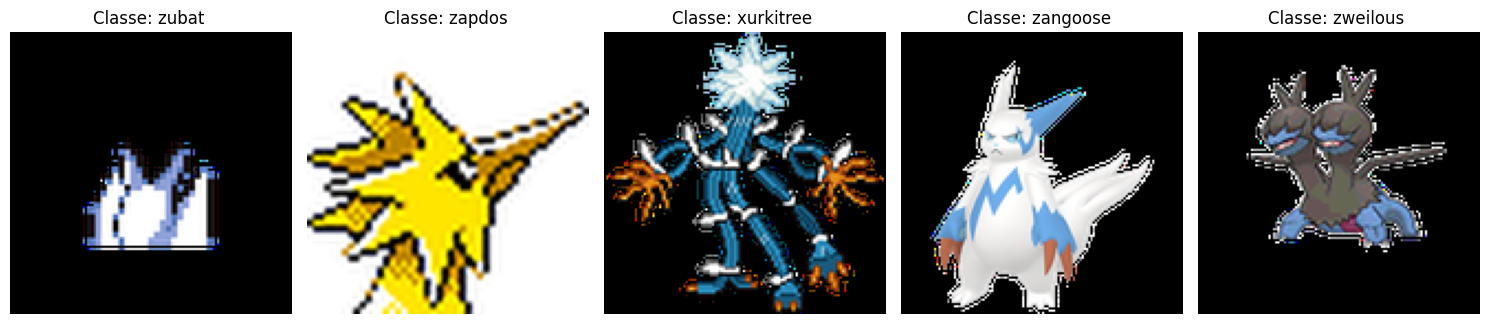

In [34]:
# Visualizar 5 exemplos do conjunto de treino
class_names = list(train_generator.class_indices.keys())
num_examples = 5

fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
train_images, train_labels = next(train_generator)

for i in range(num_examples):
    img = train_images[i]
    axes[i].imshow(img)
    axes[i].set_title(f"Classe: {class_names[np.argmax(train_labels[i])]} ")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

O Keras não possui uma métrica nativa de F1-Score, e por isso a solução mais comum é criar uma métrica personalizada para computá-la a partir das métricas básicas de precisão e recall. Segue a idéia:

A classe F1Score herda de tf.keras.metrics.Metric, o que permite criar métricas personalizadas para serem usadas com o TensorFlow/Keras.  
Definimos duas métricas auxiliares: Precision e Recall (essas duas métricas serão usadas para calcular o F1-Score.)  

Lembrando que `precision` mede a proporção de predições positivas corretas, e `recall` mede a proporção de instâncias positivas que foram corretamente identificadas, ou seja, quantas das instâncias reais positivas foram capturadas pelo modelo.  

**`name="f1_score":`** Esse é o nome da métrica personalizada que será exibido durante o treinamento e avaliação.  

**`super(F1Score, self).__init__(name=name, kwargs):`** Chama o inicializador da classe pai Metric para garantir que a classe personalizada seja registrada corretamente no TensorFlow/Keras.

In [35]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

O próximo método é chamado durante o treinamento e a avaliação do modelo para atualizar o estado da métrica.  
Ele recebe os valores verdadeiros (y_true) e preditos (y_pred), e, se necessário, os pesos amostrais (sample_weight). De modo que:

**`self.precision.update_state(y_true, y_pred, sample_weight):`** Atualiza o cálculo da precisão com base nos valores verdadeiros e preditos.
**`self.recall.update_state(y_true, y_pred, sample_weight):`** Atualiza o cálculo do recall com base nos valores verdadeiros e preditos.

In [36]:
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

Este método é chamado para calcular o valor da métrica (o F1-Score). Ele retorna o valor final da métrica com base nos valores de precisão e recall que foram atualizados. (A fórmula é uma média harmônica entre a precisão e o recall).

**OBS:** O professor pode perguntar sobre esse epsilon `tf.keras.backend.epsilon()` -  ele é um pequeno valor constante (tipicamente 
1×10^(-7)) que é somado no denominador para evitar divisão por zero, caso precision + recall seja muito pequeno ou zero.

In [37]:
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

O próximo método é chamado para resetar o estado das métricas de precisão e recall. Isso é necessário entre as épocas de treinamento ou quando você deseja limpar as estatísticas internas para um novo cálculo.

In [38]:
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

**OBS:** Aqui é a CNN (Pode por no chatGPT para entender melhor o funcionamento dela)

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Explicação do problema
# O objetivo deste modelo é classificar imagens de Pokémon utilizando uma Rede Neural Convolucional (CNN).
# O dataset contém múltiplas classes, cada uma representando um Pokémon diferente. O modelo será treinado,
# avaliado e testado para prever corretamente qual Pokémon está presente em cada imagem.


# Parâmetros
img_size = (128, 128)
batch_size = 32

# Pré-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Criar os geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Definir a métrica F1 personalizada
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Criar a CNN
model = Sequential([  
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Exibir arquitetura do modelo
model.summary()

# Compilar o modelo com as métricas de precisão, recall e F1Score
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

# Função para coletar as métricas durante o treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

# Avaliar o modelo no conjunto de teste
loss, accuracy, precision, recall, f1_score_value = model.evaluate(test_generator)
print(f'Loss no teste: {loss:.4f}, Acurácia no teste: {accuracy:.4f}, Precisão no teste: {precision:.4f}, Recall no teste: {recall:.4f}, F1-Score no teste: {f1_score_value:.4f}')

Found 1028 images belonging to 50 classes.
Found 131 images belonging to 50 classes.
Found 162 images belonging to 50 classes.


/home/kauansoares/UFC/IA/IA/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 19:05:57.501100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,528,882 (24.91 MB)

 Trainable params: 6,528,882 (24.91 MB)

 Non-trainable params: 0 (0.00 B)

/home/kauansoares/UFC/IA/IA/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-02-25 19:06:07.279947: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-02-25 19:06:09.153023: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 1/33 ━━━━━━━━━━━━━━━━━━━━ 6:11 12s/step - accuracy: 0.0625 - f1_score: 0.0000e+00 - loss: 3.9552 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-02-25 19:06:09.990701: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-02-25 19:06:12.067214: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 2/33 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.0469 - f1_score: 0.0000e+00 - loss: 4.0242 - precision: 0.0000e+00 - recall: 0.0000e+00 

2025-02-25 19:06:13.092015: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0458 - f1_score: 0.0000e+00 - loss: 3.8867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2519 - val_f1_score: 0.0000e+00 - val_loss: 3.4110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2700 - f1_score: 0.0667 - loss: 2.9990 - precision: 0.4879 - recall: 0.0362 - val_accuracy: 0.5344 - val_f1_score: 0.3145 - val_loss: 2.1188 - val_precision: 0.8929 - val_recall: 0.1908
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5705 - f1_score: 0.5278 - loss: 1.6446 - precision: 0.8249 - recall: 0.3893 - val_accuracy: 0.8092 - val_f1_score: 0.7143 - val_loss: 1.0369 - val_precision: 0.9494 - val_recall: 0.5725
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 931ms/step - accuracy: 0.8053 - f1_score: 0.7668 - loss: 0.8230 - precision: 0.9141 - recall: 0.6610 - val_accuracy: 0.8931 - val_f1_score: 0.8750 - val_loss: 0.5694 - val_precision: 0.9633 - val_re

# 📌 Resumo das Camadas Finais da CNN (A partir de Flatten)

## 🎯 Objetivo:
Após extrair características visuais, as camadas finais **combinam essas informações para realizar a classificação**.

---

## 🔹 1. Camada **Flatten (Achatamento)**
📌 **Função:**  
Transforma os mapas de características (matrizes 2D) em um **vetor 1D** para ser processado pelas camadas densas.

✅ **Entrada:**  
Matriz de características extraídas pelas camadas convolucionais (ex.: `8x8x128`).

🎯 **Saída:**  
Vetor linear (`8192`, se `8*8*128`).

```python
Flatten()
```

## 🔹 2. Camada Densa (256 Neurônios, ReLU)

📌 **Função:** 
Combina as características extraídas para reconhecer padrões abstratos e tomar decisões.

✅ **Parâmetros** 

    Dense(256, activation='relu')
    256 neurônios aprendem padrões combinados.
    ReLU impede valores negativos e melhora o treinamento.

💡 **O que acontece aqui?** 

    "Se há bordas pontiagudas e tom laranja predominante, é Charmander."
    "Se há orelhas arredondadas e tom amarelo, é Pikachu."

```python
Dense(256, activation='relu')
```

## 🔹 3. Camada Dropout (50%)

📌 **Função:** 
Reduz overfitting desativando aleatoriamente 50% dos neurônios dessa camada a cada iteração.

✅ **Parâmetros** 

    Dropout(0.5)

🎯 **Benefício:** 

    ❌ Evita que o modelo fique muito dependente de neurônios específicos.
    ✅ Melhora generalização para novas imagens.

```python
Dropout(0.5)
```

## 🔹 4. Camada Densa Final (Saída, Softmax)

📌 **Função:** 
Gera as probabilidades para cada classe de Pokémon.

✅ **Parâmetros** 

    Dense(num_classes, activation='softmax')
    Número de neurônios = número de classes (ex.: 4 para Pikachu, Charmander, Bulbasaur e Squirtle).
    Softmax converte valores em probabilidades.

🎯 **Exemplo de saída:**

[Pikachu: 0.80, Charmander: 0.15, Bulbasaur: 0.03, Squirtle: 0.02]

➡ Resposta final: Pikachu! ✅

```python
Dense(num_classes, activation='softmax')
```

# 📌 Resumo Geral das Camadas
- Camada	Função Principal	Detalhes
- Flatten	Transforma mapas de características em um vetor 1D.	Entrada: matriz → Saída: vetor
- Dense (256, ReLU)	Aprende relações complexas entre padrões extraídos.	256 neurônios totalmente conectados.
- Dropout (50%)	Previne overfitting desativando neurônios aleatoriamente.	Evita que o modelo memorize o conjunto de treino.
- Dense (Softmax)	Gera as probabilidades de cada classe.	Número de neurônios = número de classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


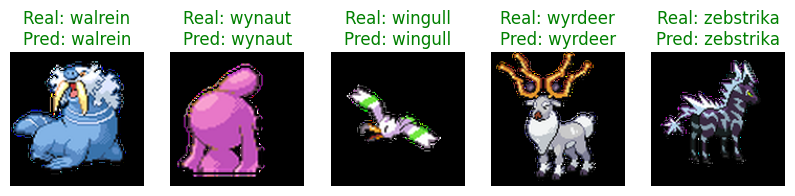

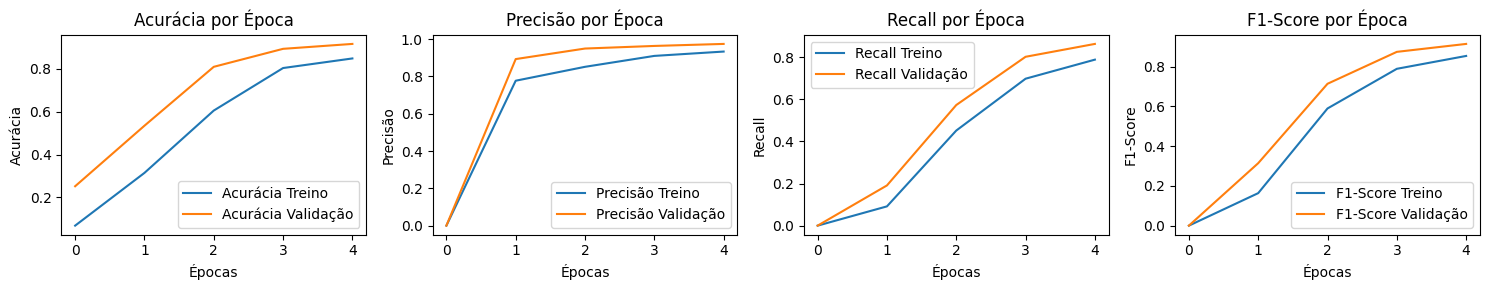

In [67]:
# Mostrar algumas imagens de teste com rótulos reais e preditos
class_names = list(train_generator.class_indices.keys())
images, labels = next(test_generator)
predictions = model.predict(images)
pred_labels = np.argmax(predictions, axis=1)

num_images = min(len(images), 5)

fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
for i in range(num_images):
    axes[i].imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[pred_labels[i]]
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Real: {true_label}\nPred: {predicted_label}", color=color)
    axes[i].axis("off")
plt.show()

# Plotar as curvas das métricas
plt.figure(figsize=(15, 3))

# Acurácia
plt.subplot(1, 4, 1)
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia por Época')

# Precisão
plt.subplot(1, 4, 2)
plt.plot(history.history['precision'], label='Precisão Treino')
plt.plot(history.history['val_precision'], label='Precisão Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão por Época')

# Recall
plt.subplot(1, 4, 3)
plt.plot(history.history['recall'], label='Recall Treino')
plt.plot(history.history['val_recall'], label='Recall Validação')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall por Época')

# F1-Score
plt.subplot(1, 4, 4)
plt.plot(history.history['f1_score'], label='F1-Score Treino')
plt.plot(history.history['val_f1_score'], label='F1-Score Validação')
plt.xlabel('Épocas')
plt.ylabel('F1-Score')
plt.legend()
plt.title('F1-Score por Época')

plt.tight_layout()
plt.show()

No contexto do treinamento de modelos de machine learning, especialmente em classificação, acurácia e precisão são métricas diferentes que avaliam diferentes aspectos do desempenho do modelo.

Acurácia: Proporção de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos) em relação ao total de previsões feitas. É uma métrica geral que indica a porcentagem de previsões corretas feitas pelo modelo. 

        Acurácia = (Verdadeiros positivos + Verdadeiros negativos) / Total de previsões


Precisão: A proporção de verdadeiros positivos em relação ao total de previsões positivas feitas pelo modelo. Mede a exatidão das previsões positivas do modelo. É particularmente útil quando o custo de falsos positivos é alto.

        Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)


Recall: É a proporção de verdadeiros positivos em relação ao total de positivos reais (verdadeiros positivos + falsos negativos). Mede a capacidade do modelo de identificar corretamente todas as instâncias positivas.

        Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

F1-Score: É a média harmônica da precisão e do recall. O F1-score é uma métrica útil quando se precisa equilibrar precisão e recall, especialmente em situações onde há uma distribuição desigual das classes.

        F1-Score = 2 x (Precisão x Recall) / (Precisão + Recall)


Isso permite uma avaliação completa do desempenho do modelo, considerando diferentes aspectos importantes para a tarefa de classificação.
